In [85]:
# Hide raw notebook code in exported HTML
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show) {
   $('div.input').hide();
 } else {
   $('div.input').show();
 }
 code_show = !code_show
} 
$(document).ready(code_toggle);
</script>
<form><input type="button" value="Return home" onclick="location.href='https://mlnoga.github.io/covid19-analysis/'"></input>
<input type="button" value="Show/hide code" onclick="code_toggle()"></input></form>

<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-161715363-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-161715363-1');
</script>
''')

# Predicting Covid-19 case fatality rates based on demographics

[Riou, Counotte, Hauser and Althaus](https://www.medrxiv.org/content/10.1101/2020.03.04.20031104v1.full.pdf) have published an analysis of case fatality rates for Covid-19. They start with crude CFR, that is, the number of deaths divided by the number of confirmed cases at that point in time. They then adjust for delayed mortality, because time passes between first symptoms and more severe illness. They also adjust for unidentified cases, to arrive at an adjusted CFR for symptomatic infections. This adjusted symptomatic CFR is projected at 3.3%, somewhat below the current global average as of March 23rd. By age group, their adjusted symptomatic CFR ranges from 0.019% for children below the age of ten, to 36% for senior citizens aged 80 and above.

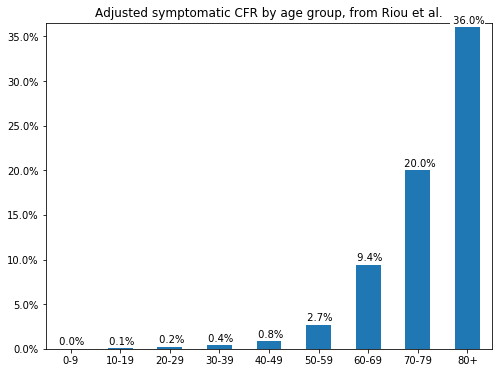

In [53]:
# Import required libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# Read adjusted symptomatic CFRs, convert percent values to floats
mort=pd.read_csv("covid19-cfr-by-age.csv")
for c in mort.columns:
    mort[c][0]=float(mort[c][0].strip('%'))/100

# Plot them
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Adjusted symptomatic CFR by age group, from Riou et al.')
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.margins(0.015)
mort.T.plot(ax=ax, kind='bar', stacked=False, color="tab:blue")
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for i, v in enumerate(list(mort.T[mort.T.columns[0]])):
    ax.text(i, v+0.0025, " %.1f%%" % (v*100), ha='center', va='bottom', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()


Let's assume for a second that confirmed cases as of March 23rd largely are symptomatic cases, because most countries are focusing testing resources on patients with symptoms and/or connections to a known confirmed case. Then the adjusted CFR for symptomatic infectations from Riou et al. should provide a rough indication of local outcomes to expect. 

To better understand the possible impact on populations, we want to combine the age-segmented data from Riou et al. with per-country [demographic data](https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F07_1_POPULATION_BY_AGE_BOTH_SEXES.xlsx) published by the UN. Let's have a look at their data, aggregated into the same age brackets as Riou et al.

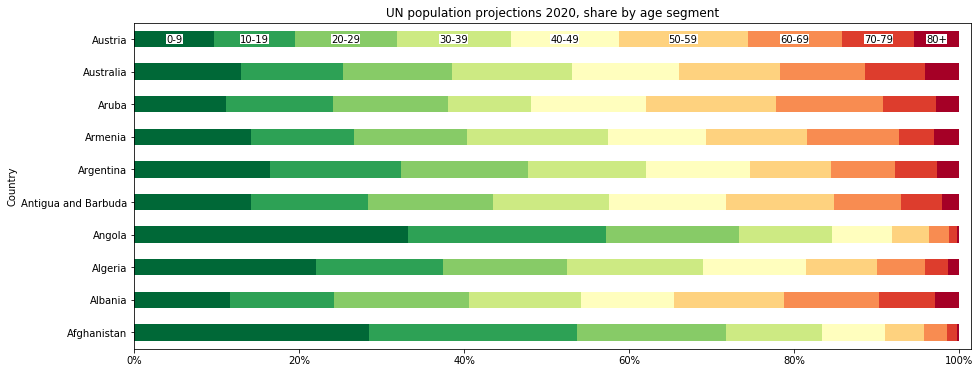

In [83]:
# read population demographics
df=pd.read_csv("population-by-age.csv")
df=df.groupby("Country").sum()

# sum up into decades values compatible with Covid-19 CFR format
for i in range(8):
    lower="%d-%d" % (0+i*10, 4+i*10)
    upper="%d-%d" % (5+i*10, 9+i*10)
    comb ="%d-%d" % (0+i*10, 9+i*10)
    df[comb]=df[[lower, upper]].sum(axis=1)
    df=df.drop(labels=[lower, upper], axis=1)
remaining=["80-84", "85-89", "90-94", "95-99", "100+"]
df["80+"]=df[remaining].sum(axis=1)
df=df.drop(labels=remaining, axis=1)

# Calculate shares
dfSum=df.sum(axis=1)
dfShare=df.divide(dfSum, axis=0)

# Plot a few of them
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('UN population projections 2020, share by age segment')
ax.xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.margins(0.015)
dfShare.iloc[0:10,:].plot(ax=ax, kind='barh', stacked=True, cmap="RdYlGn_r")
#ax.invert_yaxis()
ax.get_legend().remove()

cols=list(dfShare.columns)
cty =9
val =list(dfShare.iloc[cty,:])
sum=0
for i in range(len(cols)):
    if val[i]>0.05:
        ax.text(sum+val[i]/2, cty, cols[i], ha='center', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
    sum+=val[i]
plt.show()


To project expected CFRs by country for symptomatic cases, we take the weighted sum of all age brackets. Note that projected values for Greece of 6.5% are coming in below currently reported crude CFRs for the country as of March 26th, possibly due to overwhelmed health systems. As do projected figures for China of 3.3%, where local health systems in the Wuhan area were also initially overwhelmed.  

Fingers crossed these values don't materialize for other countries. Stay safe, stay healthy, look after your loved ones.

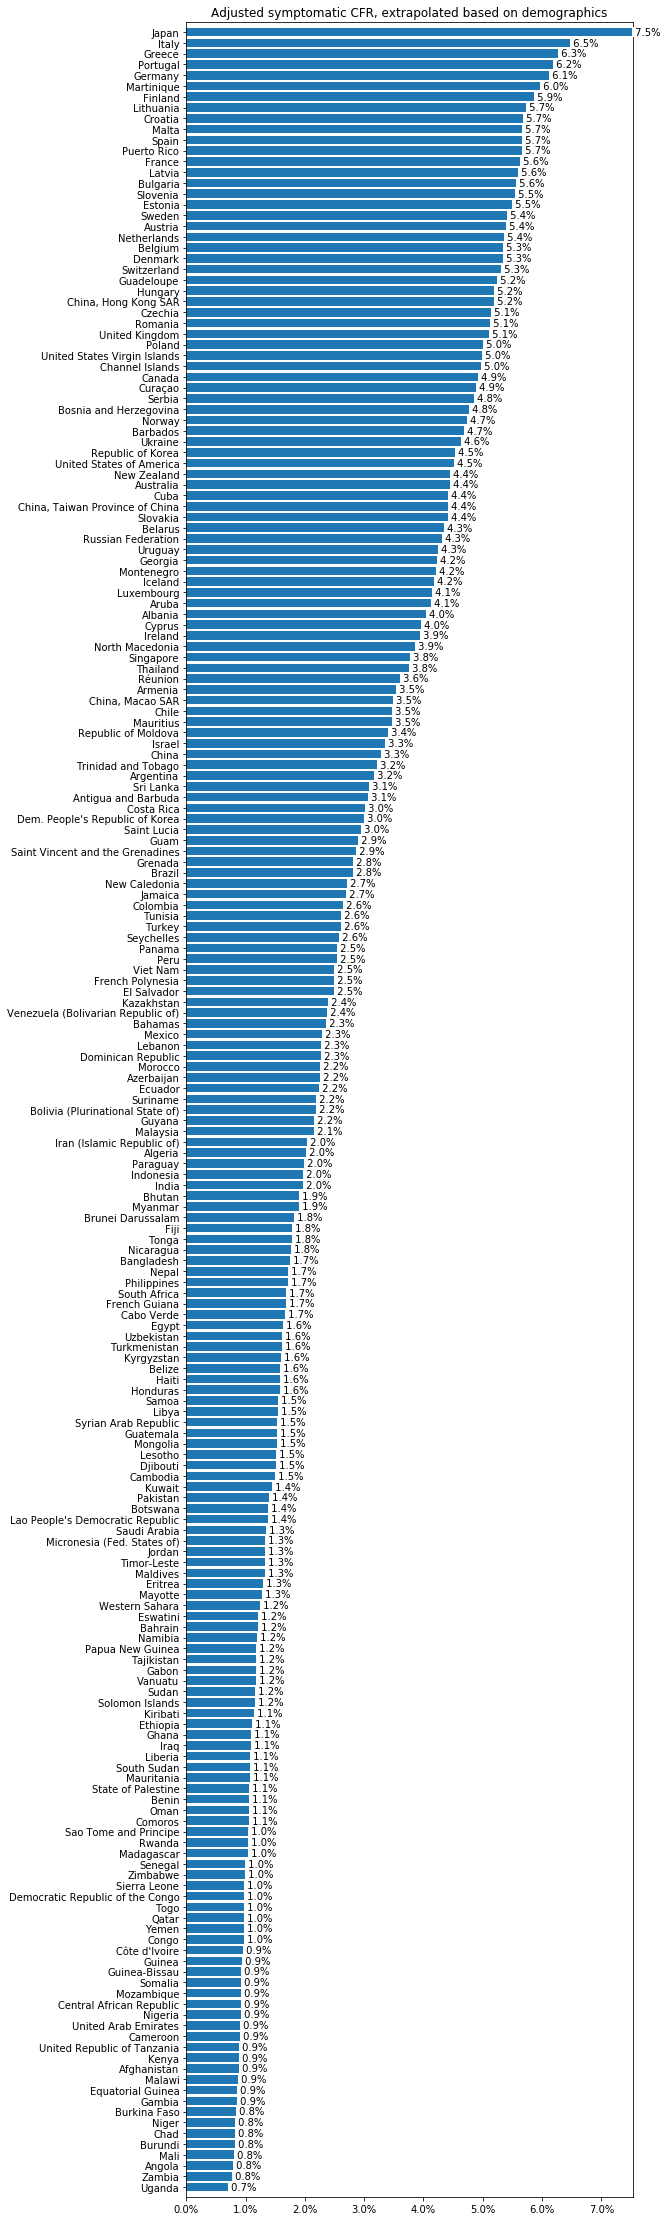

In [1]:
# Combine country demographics with CFRs by age group
validColumns=list(df.columns)
morts=list(mort[c][0] for c in validColumns)
df["CFR"]=(df[validColumns]*morts).sum(axis=1)/df[validColumns].sum(axis=1)
df=df.sort_values("CFR", ascending=False)

# Plot results
fig = plt.figure(figsize=(8, 40))
ax = fig.add_subplot(1, 1, 1)
ax.margins(0.0025)
ax.set_title("Adjusted symptomatic CFR, extrapolated based on demographics")
ax.xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.invert_yaxis()
ax.barh(df.index, df["CFR"])
for i, v in enumerate(df["CFR"]):
    ax.text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))